In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/harness-the-challenges-of-qa4mre-in-your-researc")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/harness-the-challenges-of-qa4mre-in-your-researc


In [2]:
import pandas as pd
import numpy as np
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.initializers import Constant
sns.set()

In [3]:
os.listdir('/kaggle/input/harness-the-challenges-of-qa4mre-in-your-researc')

['2013.alzheimers.EN_train.csv',
 '2012.main.RO_train.csv',
 '2011.main.ES_train.csv',
 '2012.main.ES_train.csv',
 '2013.main.RO_train.csv',
 '2011.main.RO_train.csv',
 '2013.main.ES_train.csv',
 '2012.main.DE_train.csv',
 '2012.main.IT_train.csv',
 '2012.main.AR_train.csv',
 '2013.entrance_exam.EN_train.csv',
 '2012.main.BG_train.csv',
 '2012.main.EN_train.csv',
 '2011.main.IT_train.csv',
 '2011.main.DE_train.csv',
 '2013.main.AR_train.csv',
 '2011.main.EN_train.csv',
 '2012.alzheimers.EN_train.csv',
 '2013.main.BG_train.csv',
 '2013.main.EN_train.csv']

In [4]:
df = pd.read_csv('/kaggle/input/harness-the-challenges-of-qa4mre-in-your-researc/2012.main.EN_train.csv')
df.head()

,topic_id,topic_name,test_id,document_id,document_str,question_id,question_str,answer_options,correct_answer_id,correct_answer_str
0,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,1,What is the economic reason for the almost tot...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",2,high drug prices
1,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,2,"What approach can be used to combat AIDS, unju...","{'answer_id': array(['1', '2', '3', '4', '5'],...",4,addressing them together
2,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,3,What is the goal of the ABC strategy?,"{'answer_id': array(['1', '2', '3', '4', '5'],...",3,"promoting abstinence, faithfulness, and use of..."
3,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,4,What objective did the 2001-2009 American admi...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",5,increasing the profits of U.S. pharmaceutical ...
4,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,5,Why must Kenyan women have the right to own an...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",1,to support their own families


In [5]:
df.shape

(160, 10)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   topic_id            160 non-null    int64 
 1   topic_name          160 non-null    object
 2   test_id             160 non-null    int64 
 3   document_id         160 non-null    int64 
 4   document_str        160 non-null    object
 5   question_id         160 non-null    int64 
 6   question_str        160 non-null    object
 7   answer_options      160 non-null    object
 8   correct_answer_id   160 non-null    int64 
 9   correct_answer_str  160 non-null    object
dtypes: int64(5), object(5)
memory usage: 12.6+ KB


In [7]:
df.isnull().sum()

topic_id              0
topic_name            0
test_id               0
document_id           0
document_str          0
question_id           0
question_str          0
answer_options        0
correct_answer_id     0
correct_answer_str    0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df['answer_options'][0]

"{'answer_id': array(['1', '2', '3', '4', '5'], dtype=object), 'answer_str': array(['availability of ARVs in wealthy countries', 'high drug prices',\n       'external debt cancellation for the African governments',\n       'profits of pharmaceutical companies', 'lack of political plans'],\n      dtype=object)}"

In [10]:
'The answer options is: ' + df['answer_options'][0].split('[')[2].split(']')[0]

"The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices',\n       'external debt cancellation for the African governments',\n       'profits of pharmaceutical companies', 'lack of political plans'"

In [11]:
def answer_options_cleaning(text):
    text = 'The answer options is: '+ text.split('[')[2].split(']')[0]
    text = re.sub('[\n]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [12]:
df['answer_options_c'] = df['answer_options'].apply(answer_options_cleaning)

In [13]:
df.head()

,topic_id,topic_name,test_id,document_id,document_str,question_id,question_str,answer_options,correct_answer_id,correct_answer_str,answer_options_c
0,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,1,What is the economic reason for the almost tot...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",2,high drug prices,The answer options is: 'availability of ARVs i...
1,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,2,"What approach can be used to combat AIDS, unju...","{'answer_id': array(['1', '2', '3', '4', '5'],...",4,addressing them together,"The answer options is: 'government policies', ..."
2,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,3,What is the goal of the ABC strategy?,"{'answer_id': array(['1', '2', '3', '4', '5'],...",3,"promoting abstinence, faithfulness, and use of...","The answer options is: ""promoting women's soci..."
3,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,4,What objective did the 2001-2009 American admi...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",5,increasing the profits of U.S. pharmaceutical ...,"The answer options is: ""combating the crisis g..."
4,1,AIDS,1,1,\nAfrican Women Confront Bush's AIDS PolicyReb...,5,Why must Kenyan women have the right to own an...,"{'answer_id': array(['1', '2', '3', '4', '5'],...",1,to support their own families,The answer options is: 'to support their own f...


In [14]:
df['answer_options_c'][0]

"The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'"

In [15]:
def word_cloud(column):
    plt.figure(figsize = (9, 9))
    all_sents = ' '.join([sentence for sentence in df[column]])
    wordcl = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wordcl)
    plt.title(column, fontsize = 15)
    plt.axis('off')
    plt.show()

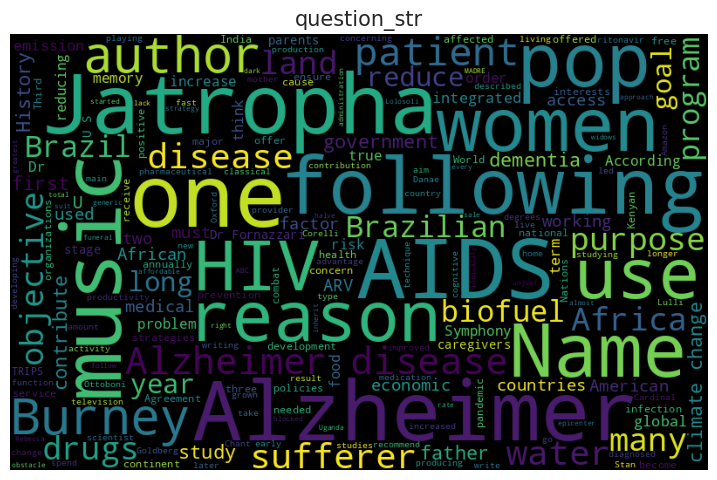

In [16]:
word_cloud('question_str')

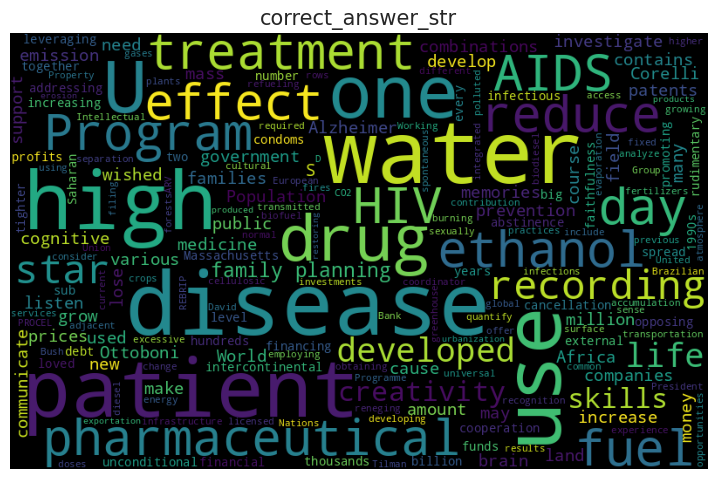

In [17]:
word_cloud('correct_answer_str')

In [18]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['question_str'])
seq = tokenizer.texts_to_sequences(df['question_str'])

In [19]:
vocab_size = len(tokenizer.word_index) + 1
maxlen = max([len(i) for i in seq])

In [20]:
vocab_size

675

In [21]:
maxlen

23

In [22]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [23]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anmolkumar/glove-embeddings")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/glove-embeddings


In [24]:
os.listdir('/kaggle/input/glove-embeddings')

['glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'glove.6B.100d.txt']

In [25]:
embedding_matrix = dict()
glove = open('/kaggle/input/glove-embeddings/glove.6B.100d.txt', encoding = 'utf8')
for line in glove:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove.close()

In [26]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [27]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       ...,
       [-0.16376001,  0.52354997, -0.73949999, ..., -0.88248998,
         0.74131   ,  0.50603998],
       [ 0.18325   , -0.067717  , -1.00520003, ..., -0.23339   ,
        -0.25764   ,  0.24228001],
       [-0.42341   ,  0.68835998, -0.72233999, ...,  0.26301   ,
         0.083785  , -0.33103001]])

In [28]:
le = LabelEncoder()

In [29]:
y = le.fit_transform(df['answer_options_c'])

In [30]:
print('The number of classes is:', df['answer_options_c'].nunique())

The number of classes is: 160


In [31]:
model = Sequential()

In [32]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(15)))
model.add(Dense(160, activation = 'softmax'))

In [33]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [34]:
history = model.fit(pad_seq, y, epochs = 130)

Epoch 1/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.0021 - loss: 5.0780    
Epoch 2/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0042 - loss: 5.0814     
Epoch 3/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0259 - loss: 5.0600 
Epoch 4/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0413 - loss: 5.0428 
Epoch 5/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0499 - loss: 5.0320 
Epoch 6/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0247 - loss: 5.0300     
Epoch 7/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0455 - loss: 5.0139 
Epoch 8/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0320 - loss: 5.0008     
Epoch 9/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0488 - loss: 4.9875 
Epoch 10/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0707 - loss: 4.9477 
Epoch 11/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0666 - loss: 4.9350 
Epoch 12/130
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accurac

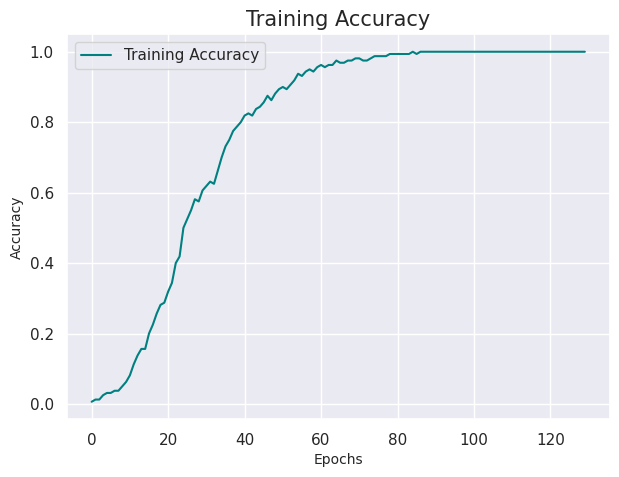

In [35]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.title('Training Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

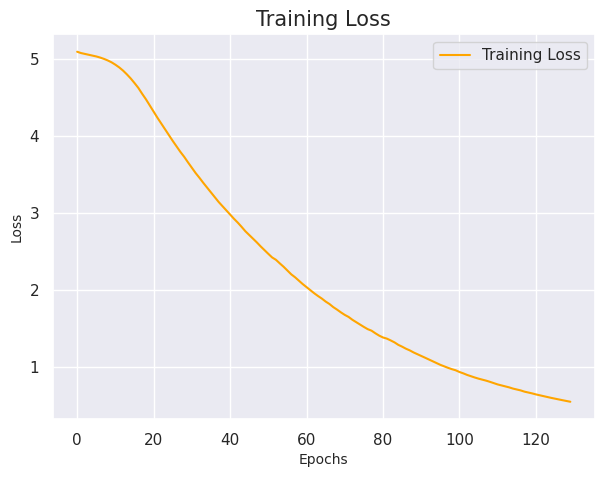

In [36]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['loss'], label = 'Training Loss', color = 'orange')
plt.title('Training Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [37]:
df['question_str'][0]

'What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?'

In [38]:
df['answer_options_c'][0]

"The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'"

In [39]:
df['question_str'][1]

"What approach can be used to combat AIDS, unjust economic policies and women's inequality?"

In [40]:
df['answer_options_c'][1]

"The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'"

In [41]:
df['question_str'][2]

'What is the goal of the ABC strategy?'

In [42]:
df['answer_options_c'][2]

'The answer options is: "promoting women\'s social and economic rights", "combating women\'s inequalities", \'promoting abstinence, faithfulness, and use of condoms.\', \'ignoring poverty, social inequality and traditional ways\', \'promoting the prevention and treatment programs\''

In [43]:
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(df['correct_answer_str'])
seq2 = tokenizer2.texts_to_sequences(df['correct_answer_str'])

In [44]:
vocab_size2 = len(tokenizer2.word_index) + 1
maxlen2 = max([len(i) for i in seq2])

In [45]:
vocab_size2

504

In [46]:
maxlen2

19

In [47]:
pad_seq2 = pad_sequences(seq2, maxlen = maxlen2, padding = 'post')

In [49]:
y2 = le.fit_transform(df['answer_options_c'])

In [50]:
embedding_vectors2 = np.zeros((vocab_size2, 100))
for word, index in tokenizer2.word_index.items():
    vec2 = embedding_matrix.get(word)
    if vec2 is not None:
        embedding_vectors2[index] = vec2

In [51]:
embedding_vectors2

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.1529    , -0.24279   ,  0.89837003, ..., -0.59100002,
         1.00390005,  0.20664001],
       ...,
       [ 0.14212   ,  0.039759  ,  0.064196  , ...,  0.32365999,
        -0.45378   ,  0.062197  ],
       [-0.30324   , -0.023145  ,  0.33605999, ..., -0.24665999,
         0.49215999, -0.099928  ],
       [-0.74272001,  0.1349    ,  0.68435001, ..., -0.47889   ,
         0.41927001, -0.14354999]])

In [70]:
model2 = Sequential()

In [71]:
model2.add(Embedding(vocab_size2, 100, embeddings_initializer = Constant(embedding_vectors2), trainable = False))
model2.add(Bidirectional(LSTM(30)))
model2.add(Dense(160, activation = 'softmax'))

In [72]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
history2 = model2.fit(pad_seq2, y2, epochs = 150)

Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0000e+00 - loss: 5.0807
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0098 - loss: 5.0577     
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0284 - loss: 5.0333 
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0201 - loss: 5.0209 
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0282 - loss: 4.9959 
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0442 - loss: 4.9596 
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0644 - loss: 4.9200 
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1130 - loss: 4.8846 
Epoch 9/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0773 - loss: 4.8217 
Epoch 10/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1109 - loss: 4.7788 
Epoch 11/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1720 - loss: 4.7035 
Epoch 12/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.218

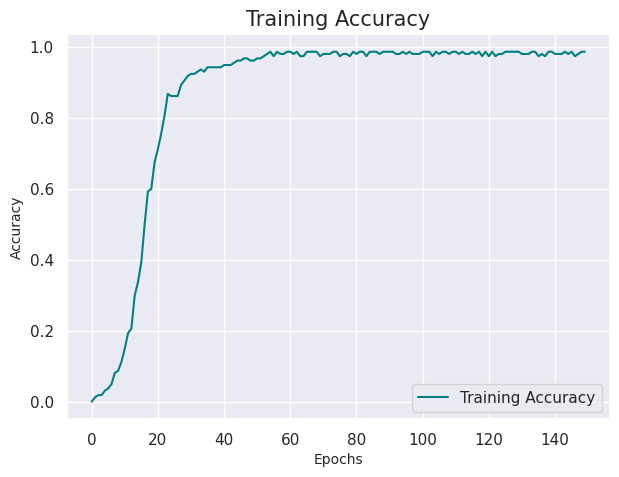

In [74]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['accuracy'], label = 'Training Accuracy', color = 'teal')
plt.title('Training Accuracy', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

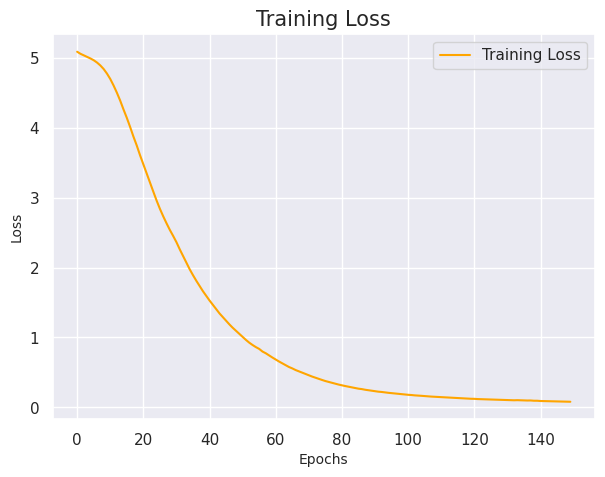

In [75]:
plt.figure(figsize = (7, 5))
plt.plot(history2.history['loss'], label = 'Training Loss', color = 'orange')
plt.title('Training Loss', fontsize = 15)
plt.xlabel('Epochs', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

In [76]:
while True:
    te = input('You: ')
    if te == 'finish':
        break
    else:
        te_seq = tokenizer.texts_to_sequences([te])[0]
        pad_te = pad_sequences([te_seq], maxlen = maxlen, padding = 'post')
        pred = le.inverse_transform([np.argmax(model.predict(pad_te))])[0]
        print('*** You: ', te)
        print('+++ Please choose one of the asnwer option:\n', pred)
        te2 = input('Your choice is: ')
        te2_seq = tokenizer2.texts_to_sequences([te2])[0]
        pad_te2 = pad_sequences([te2_seq], maxlen = maxlen2, padding = 'post')
        pred2 = le.inverse_transform([np.argmax(model2.predict(pad_te2))])[0]
        print('*** Your choice is: ', te2)
        if pred == pred2:
            print('+++ Your answer is correct.')
        else:
            print('+++ Your answer is wrong.')
        print('=========================================================================')

You:  please answer the question: What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  please answer the question: What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  high drug prices is correct


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
*** Your choice is:  high drug prices is correct
+++ Your answer is correct.


You:  What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  high drug prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  high drug prices
+++ Your answer is correct.


You:  What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  external debt cancellation for African governments


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
*** Your choice is:  external debt cancellation for African governments
+++ Your answer is wrong.


You:  the question is What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  the question is What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  the answer is high drug prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  the answer is high drug prices
+++ Your answer is correct.


You:  the question is What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  the question is What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  i think high drug prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  i think high drug prices
+++ Your answer is correct.


You:  please answer the question: What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  please answer the question: What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  high drug prices is correct


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
*** Your choice is:  high drug prices is correct
+++ Your answer is correct.


You:  would you tell us What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  would you tell us What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  the option high drug prices is correct


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  the option high drug prices is correct
+++ Your answer is correct.


You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  high drug price


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  high drug price
+++ Your answer is correct.


You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  hig drug prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** Your choice is:  hig drug prices
+++ Your answer is correct.


You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  high drog prices


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  high drog prices
+++ Your answer is correct.


You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  i think high drug prices is correct


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** Your choice is:  i think high drug prices is correct
+++ Your answer is correct.


You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  please answer What is the economic reason for the almost total lack of access to ARV drugs for patients in Africa?
+++ Please choose one of the asnwer option:
 The answer options is: 'availability of ARVs in wealthy countries', 'high drug prices', 'external debt cancellation for the African governments', 'profits of pharmaceutical companies', 'lack of political plans'


Your choice is:  i think hig drog prices is correct


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  i think hig drog prices is correct
+++ Your answer is correct.


You:  What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  government policies


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** Your choice is:  government policies
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  my answer is addresding them togeter


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  my answer is addresding them togeter
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  my answer is addressing them together


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
*** Your choice is:  my answer is addressing them together
+++ Your answer is correct.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  my answer id adressing them together


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
*** Your choice is:  my answer id adressing them together
+++ Your answer is correct.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  mu answer is addressing them together


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  mu answer is addressing them together
+++ Your answer is correct.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  my answer is addressing rhem togetert


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  my answer is addressing rhem togetert
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  addressing them together is the right answer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  addressing them together is the right answer
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  addressing them together approach


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  addressing them together approach
+++ Your answer is correct.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  addressing them togeter approach


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** Your choice is:  addressing them togeter approach
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  addressing them togethe


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
*** Your choice is:  addressing them togethe
+++ Your answer is wrong.


You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
*** You:  my next question is What approach can be used to combat AIDS, unjust economic policies and women's inequality?
+++ Please choose one of the asnwer option:
 The answer options is: 'government policies', 'prevention strategies', 'changing traditional ways', 'addressing them together', 'public health programs'


Your choice is:  addresing them together


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
*** Your choice is:  addresing them together
+++ Your answer is correct.


You:  finish
